# Life history trade-offs: Antibiotic Resistance and Vaccination

for the entity of this simulation we will assume the same population size $N$ and the same starting conditions for $S_0$, $I_0$ and $R_0$. The rest of the parameters varies from case to case.

In [1]:
#imports

import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact, interactive, interact_manual, fixed
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider

The parameter values were taken from Lehtinen 2018 and Colijn 2009

## SISV model modelling antibiotic resistance in response to vaccine rollout

### Model 

In order to model vaccination as a real rollout and not just a mere drop in susceptibles, we will have to create a new model, including a compartement of susceptibles $S$ and vaccinated individuals $V$. THen we have two classes of infecteds, vaccine-type $v$ and non-vaccine-type $nv$ and for each of these classes two categories, namely antibiotic sensitive $s$ and antibiotic resistant $r$. In order to track who was vaccinated and who wasn't we subdivide the $nv$ compartments further into an $nv,S$ for non-vaccine-type and from the susceptibles and $nv,V$ for non-vaccine-type from the vaccinated compartement. For the vaccine-type we don't have to make this subdivision, because the vaccine-type can only infect susceptibles but not vaccinated individuals.

![](SISV.png)

The model gives rise to the following ODE system:

$$
\begin{aligned}
\frac{dS}{dt} &= (\gamma + \tau)(I_S^{nv,S}+I_S^v) - \beta S (I_S^{nv,S}+I_S^v) + c_{\gamma}\gamma(I_R^{nv,S}+I_R^v) - \frac{\beta}{c_{\beta}}S(I_R^{nv,S}+I_R^v) - \nu S\\
\frac{dI_S^{nv,S}}{dt} &= \beta S I_S^{nv,S} - (\gamma + \tau) I_S^{nv,S}\\
\frac{dI_R^{nv,S}}{dt} &= \frac{\beta}{c_{\beta}} S I_R^{nv,S} - c_{\gamma}\gamma I_R^{nv,S}\\
\frac{dI_S^{nv,V}}{dt} &= \beta V I_S^{nv,V} - (\gamma + \tau) I_S^{nv,V}\\
\frac{dI_R^{nv,V}}{dt} &= \frac{\beta}{c_{\beta}} V I_R^{nv,V} - c_{\gamma}\gamma I_R^{nv,V}\\
\frac{dI_S^v}{dt} &= \beta S I_S^v - (\gamma + \tau) I_S^v\\
\frac{dI_R^v}{dt} &= \frac{\beta}{c_{\beta}} S dI_R^v - c_{\gamma}\gamma dI_R^v\\
\frac{dV}{dt} &= \nu S + (\gamma + \tau)I_S^{nv,V} - \beta V I_S^{nv,V} + c_{\gamma}\gamma I_R^{nv,V} - \frac{\beta}{c_{\beta}} V I_R^{nv,V}
\end{aligned}
$$

If we want to introduce a rollout of the vaccine after reaching equilibrium, we need to have sensitives and resistant individuals. In order to do this we will enforce coexistance. In order to do this we saw that the $R_0$ values for the sensitives and the resistants need to be the same as we have derived in the script SIS. $\frac{\beta}{\gamma + \tau} = \frac{\beta}{c_{\gamma}c_{\beta}\gamma}$. This is the definition of $R_0$ meaning that we get the relationship $R_{0_S} = R_{0_R}$ at equilibrium and in this state we will reach the equilibrium of coexistence. 

we can derive a condition on the antibiotic consumption rate in which case we reach coexistence:
$$
\begin{aligned}
R_{0_S} &= R_{0_R}\\
\frac{\beta}{\gamma + \tau} &= \frac{\beta}{c_{\gamma}c_{\beta}\gamma}\\
\tau &= \gamma (c_{\gamma}c_{\beta} - 1)
\end{aligned}
$$

In [91]:
#adding birth and death rates to the simple SIR model

#available population to infect

N = 1000

#prior infected susceptible and resistant
IsnvS0, IrnvS0, IsnvV0, IrnvV0, Isv0, Irv0, V0 = 1, 1, 0, 0, 1, 1, 0

#prior susceptible
S0 = N - IsnvS0 - IrnvS0 - IsnvV0 - IrnvV0 - Isv0 - Irv0 - V0

#parameters
beta = 2/N # why does frequency dependent beta make such a difference to density dependent?

#clearance rate
gamma = 1

#vaccination rate
nu = 0.01

#interval to plot
t = 500

#terms to be added because of resistance modelling
cg = 1.1
cb = 1.0
tau = gamma * (cb * cg - 1)

In [92]:
#PRE: all variables are positive integers
#POST: The SISV model on antibiotic resistance with vaccine rollout

def SISV (t, y, N, beta, gamma, cg, cb, tau, nu):
    S, IsnvS, IrnvS, IsnvV, IrnvV, Isv, Irv, V = y
    if(t<50):
        nu = 0
        dSdt = (gamma + tau) * (IsnvS + Isv) - beta * S * (IsnvS + Isv) + cg * gamma * (IrnvS + Irv) - beta/cb * S * (IrnvS + Irv) - nu * S
        # in the beginning I let all these trajectories evolve the same to have all eq. I divide by 2 to get equal numbers
        dIsnvSdt = (beta * S * IsnvS - (gamma + tau) * IsnvS)/2 
        # in the beginning I let all these trajectories evolve the same to have all eq. I divide by 2 to get equal numbers
        dIrnvSdt = (beta/cb * S * IrnvS - cg * gamma * IrnvS)/2 
        # in the beginning I let all these trajectories evolve the same to have all eq. I divide by 2 to get equal numbers
        dIsnvVdt = (beta * S * IsnvS - (gamma + tau) * IsnvS)/2 
        # in the beginning I let all these trajectories evolve the same to have all eq. I divide by 2 to get equal numbers
        dIrnvVdt = (beta/cb * S * IrnvS - cg * gamma * IrnvS)/2 
        
        dIsvdt = beta * S * Isv - (gamma + tau) * Isv
        dIrvdt = beta/cb * S * Irv - cg * gamma * Irv
        dVdt = 0 # set the vaccinated individuals to be zero until we roll the vaccine out
    else:
        dSdt = (gamma + tau) * (IsnvS + Isv) - beta * S * (IsnvS + Isv) + cg * gamma * (IrnvS + Irv) - beta/cb * S * (IrnvS + Irv) - nu * S
        dIsnvSdt = beta * S * IsnvS - (gamma + tau) * IsnvS
        dIrnvSdt = beta/cb * S * IrnvS - cg * gamma * IrnvS
        dIsnvVdt = beta * V * IsnvV - (gamma + tau) * IsnvV
        dIrnvVdt = beta/cb * S * IrnvV - cg * gamma * IrnvV
        dIsvdt = beta * S * Isv - (gamma + tau) * Isv
        dIrvdt = beta/cb * S * Irv - cg * gamma * Irv
        dVdt = nu * S + (gamma + tau) * IsnvV - beta * V * IsnvV + cg * gamma * IrnvV - beta/cb * V * IrnvV

    return dSdt, dIsnvSdt, dIrnvSdt, dIsnvVdt,dIrnvVdt, dIsvdt, dIrvdt, dVdt

### Solving the ODE system

In [93]:
#numerically integrate the ODEs
y0 = S0, IsnvS0, IrnvS0, IsnvV0, IrnvV0, Isv0, Irv0, V0
sol = solve_ivp(SISV, [0,t], y0, rtol=1e-6, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau, nu), max_step = 10000)

### Plotting the results


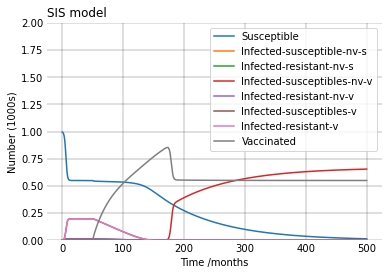

In [94]:
#plot
fig = plt.figure()
ax = fig.add_subplot(111,  axisbelow=True)
curves = ax.plot(sol.t, sol.y.T/1000)
ax.legend(curves, ['Susceptible', 'Infected-susceptible-nv-s', 'Infected-resistant-nv-s', 'Infected-susceptibles-nv-v', 'Infected-resistant-nv-v', 'Infected-susceptibles-v', 'Infected-resistant-v', 'Vaccinated'])
ax.set_xlabel('Time /months')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,2.0)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.title('SIS model', loc='left')
plt.show()

### Interactive plotting tool

In [22]:
#numerically integrate the ODEs
def interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, V):
    #defining the susceptibles for the model - will reduce the number of available hosts by introducing more vaccinated hosts
    S0 = N - V - Is0 - Ir0
    y0 = S0, Is0, Ir0
    #solve the SIS numerically
    sol = solve_ivp(SISV, [0,t], y0, method = 'RK23', dense_output = True, args=(N, beta, gamma, cg, cb, tau, nu))
    #plot the results
    fig = plt.figure()
    ax = fig.add_subplot(111,  axisbelow=True)
    curves = ax.plot(sol.t, sol.y.T/1000)
    ax.legend(curves, ['Susceptible', 'Infected-sensitive', 'Infected-resistant'])
    ax.set_xlabel('Time /months')
    ax.set_ylabel('Number (1000s)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='k', lw=0.25, ls='-')
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.title('SIS model', loc='left')
    plt.show()

In [23]:
interact(interactive_plot, y0 = fixed(y0) , t = fixed(t), N = fixed(N), beta = widgets.FloatSlider(min=0.1/N, max=4/N, step=0.1/N, value=beta), gamma = widgets.FloatSlider(min=0.1, max=1, step=0.1, value=gamma), cg = (cg), cb = (cb) , tau = widgets.FloatSlider(min=0.05, max=1, step=0.05, value=tau), V = widgets.IntSlider(min=0, max=N, step=10, value=0))

interactive(children=(FloatSlider(value=0.002, description='beta', max=0.004, min=0.0001, step=0.0001), FloatS…

<function __main__.interactive_plot(y0, t, N, beta, gamma, cg, cb, tau, V)>